## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

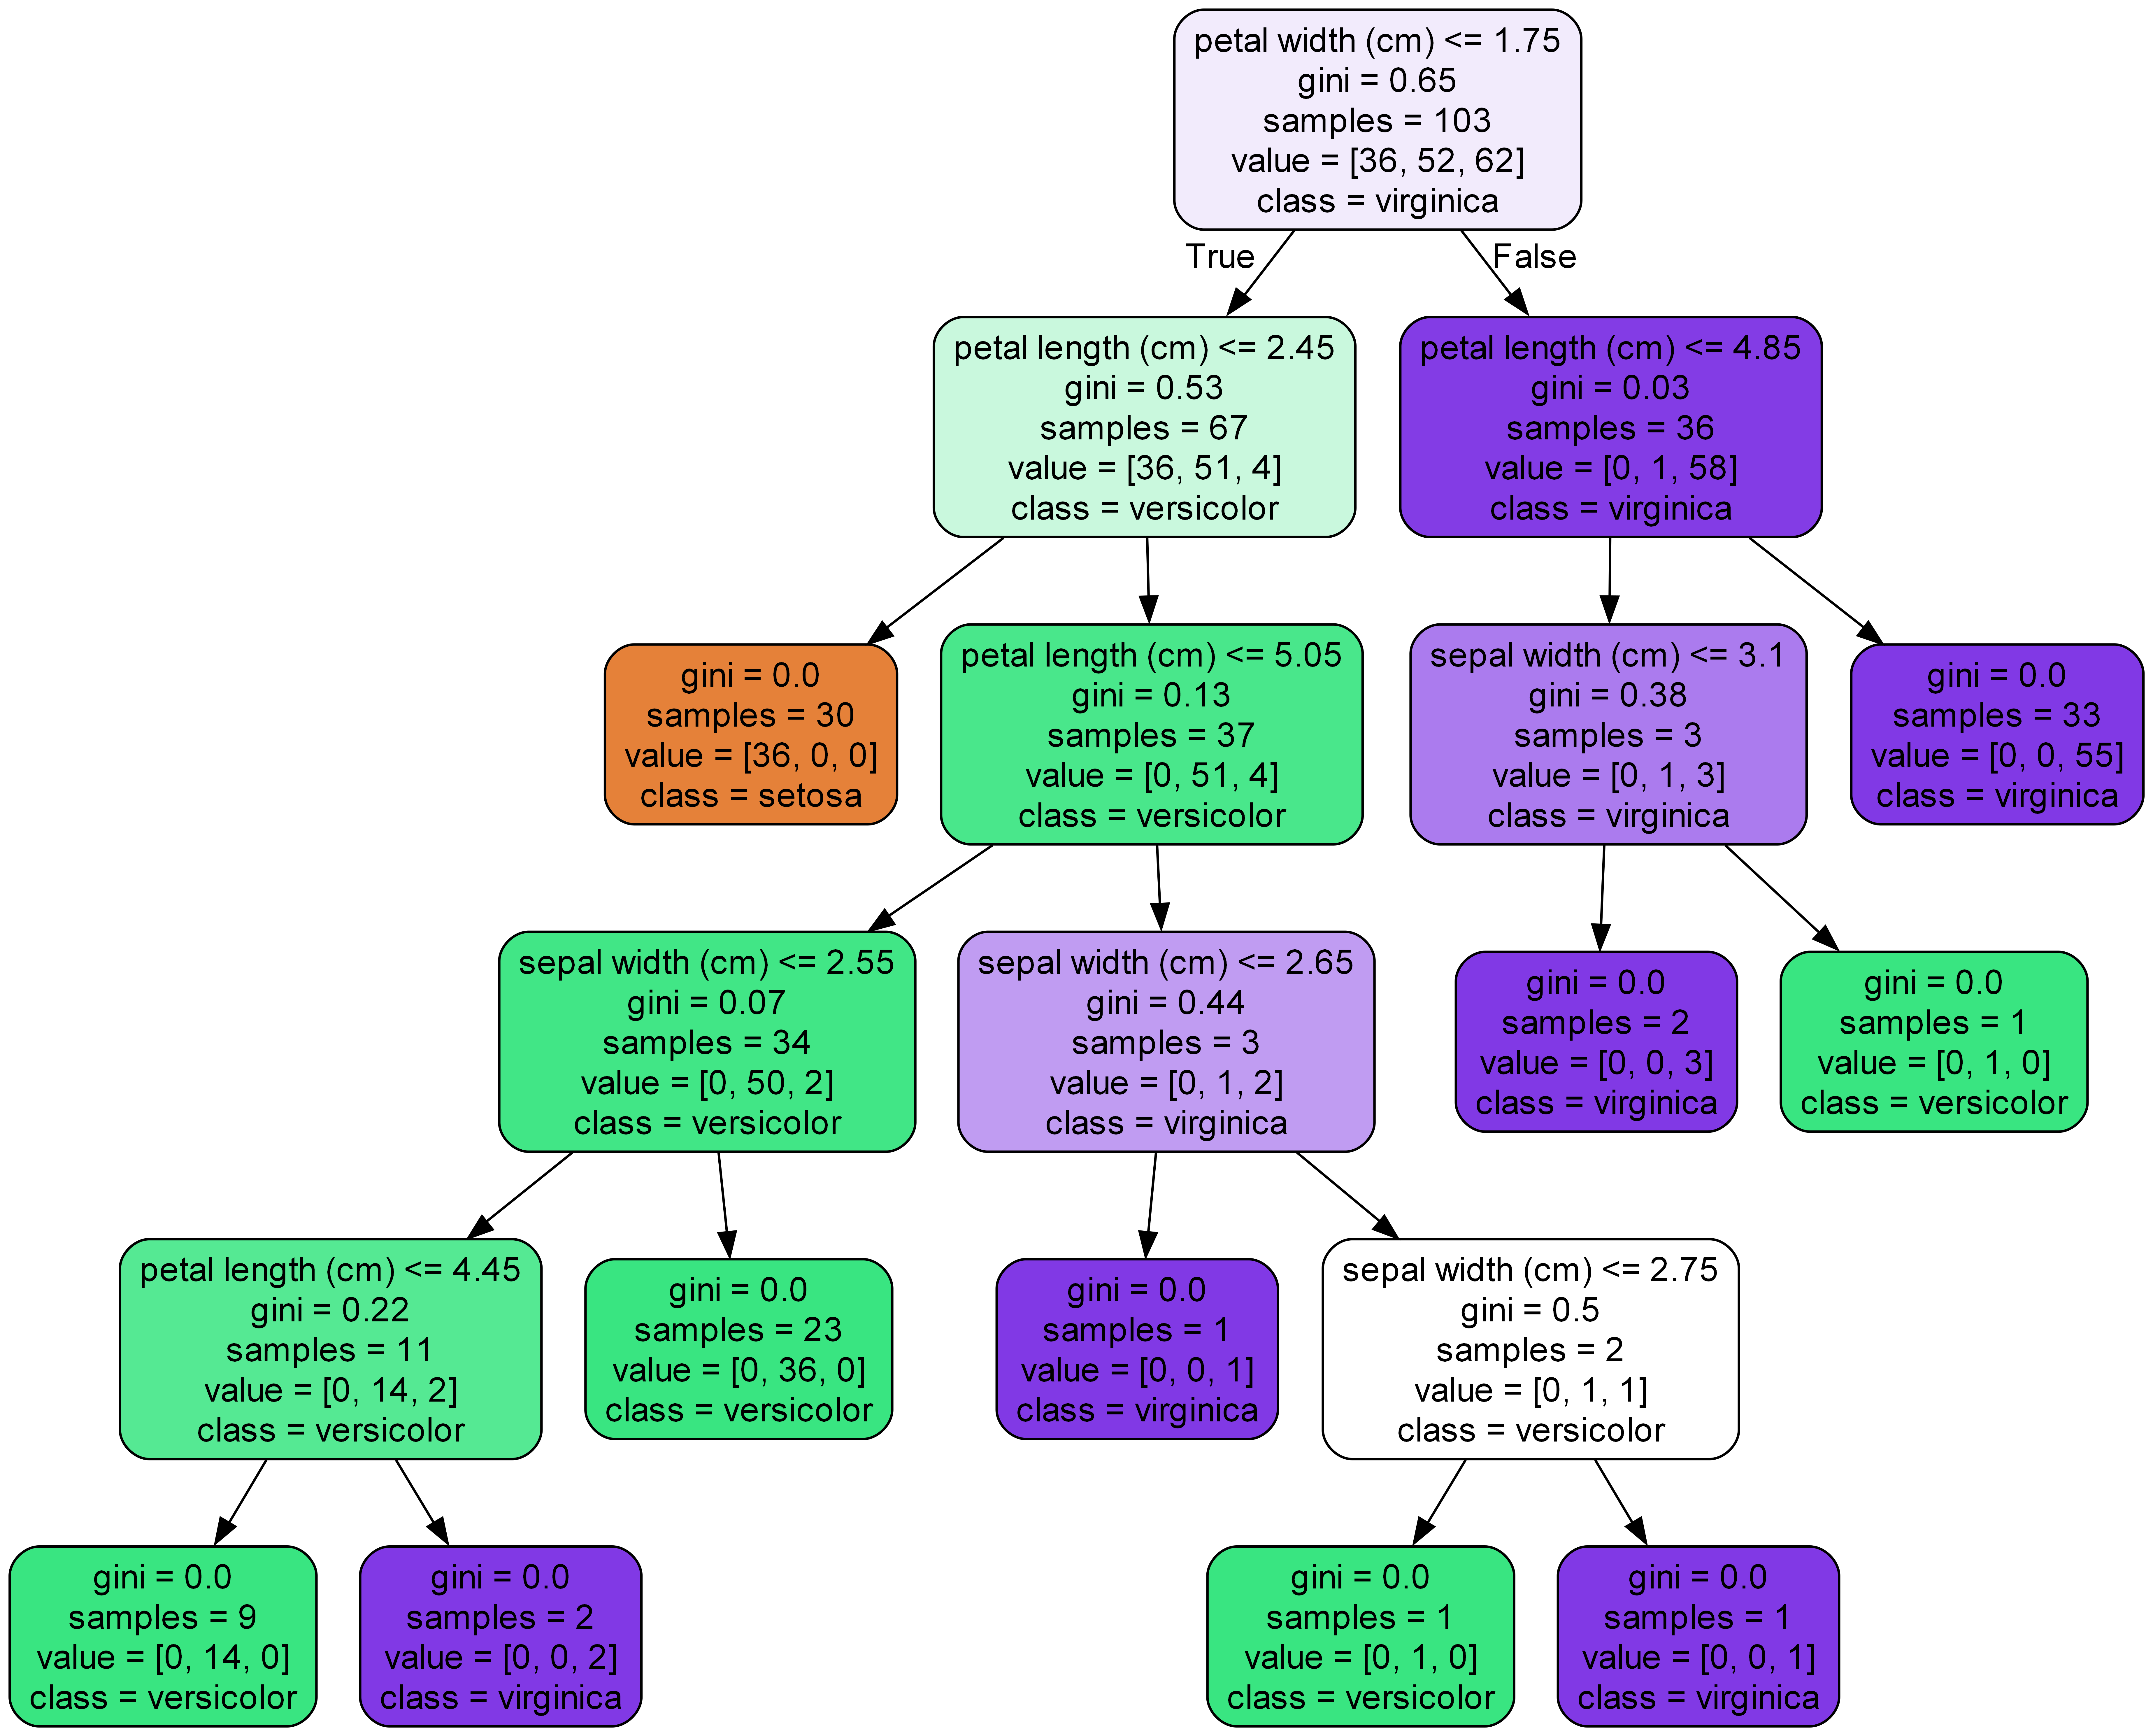

In [431]:
from sklearn.datasets import load_iris
iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

Notice how each split seperates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier **to predict the 'state' of the patient**.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [432]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

In [433]:
url ='SouthKoreacoronavirusdataset/PatientInfo.csv'
df = pd.read_csv(url)
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [434]:
df.shape

(2218, 18)

In [435]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [436]:
#counts of response variable values
df.state.value_counts()

isolated    1791
released     307
deceased      32
Name: state, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [437]:
df['n_age'] = datetime.today().year - df.birth_year

In [438]:
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,59.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released,36.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,59.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,32.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,31.0


### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [439]:
print(df.isnull().sum())

patient_id               0
global_num             904
sex                    145
birth_year             454
age                    261
country                  0
province                 0
city                    65
disease               2199
infection_case        1055
infection_order       2176
infected_by           1749
contact_number        1807
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                   88
n_age                  454
dtype: int64


In [440]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   patient_id          2218 non-null   int64  
 1   global_num          1314 non-null   float64
 2   sex                 2073 non-null   object 
 3   birth_year          1764 non-null   float64
 4   age                 1957 non-null   object 
 5   country             2218 non-null   object 
 6   province            2218 non-null   object 
 7   city                2153 non-null   object 
 8   disease             19 non-null     object 
 9   infection_case      1163 non-null   object 
 10  infection_order     42 non-null     float64
 11  infected_by         469 non-null    float64
 12  contact_number      411 non-null    float64
 13  symptom_onset_date  193 non-null    object 
 14  confirmed_date      2077 non-null   object 
 15  released_date       223 non-null    object 
 16  deceas

 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [441]:
df.disease.unique()

array([nan, True], dtype=object)

In [442]:
df.disease.fillna(0, inplace = True)

In [443]:
df.disease.unique()

array([0, True], dtype=object)

In [444]:
df['disease'].loc[df.disease == True] = 1

C:\Users\wfei2\AppData\Local\Temp\ipykernel_24864\908397736.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['disease'].loc[df.disease == True] = 1


In [445]:
df.disease.unique()

array([0, 1], dtype=object)

 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

In [446]:
mean_inpute_list = ['global_num','birth_year','infection_order','infected_by', 'contact_number']

for col in mean_inpute_list:
    print('Before impute: \n', df[col].unique())
    df[col].fillna(df[col].mean(), inplace = True)
    print('After impute: \n', df[col].unique())

Before impute: 
 [2.00e+00 5.00e+00 6.00e+00 ... 2.22e+02 4.34e+03 5.53e+03]
After impute: 
 [2.00e+00 5.00e+00 6.00e+00 ... 2.22e+02 4.34e+03 5.53e+03]
Before impute: 
 [1964. 1987. 1991. 1992. 1966. 1995. 1983. 1960. 1962. 1938. 1952. 1943.
 1945. 1944. 2000. 1941. 1936. 1985. 1961. 1980. 1958. 1986. 1968. 1950.
 1954. 1965. 1970. 1984. 1963. 1976. 1953. 1977. 1979. 1999. 1993. 1956.
 1994. 1973. 1937. 1946. 1990. 1935. 1955. 1974. 1975. 1967. 1982. 2003.
 1996. 1988. 1951. 1997. 2005. 1969. 1972. 1971. 1929. 2013. 1981. 2020.
 1989. 1978. 1998. 1959. 1949. 2007. 2004. 2001. 2012. 1939. 2006. 2002.
 1947. 2015. 1932. 1948. 1957. 1934. 1930. 1933.   nan 2009. 2018. 1942.
 2008. 2011. 2010. 2014. 2017. 2019. 1940. 1926. 1925. 1928. 1927. 1916.
 1931.]
After impute: 
 [1964.   1987.   1991.   1992.   1966.   1995.   1983.   1960.   1962.
 1938.   1952.   1943.   1945.   1944.   2000.   1941.   1936.   1985.
 1961.   1980.   1958.   1986.   1968.   1950.   1954.   1965.   1970.
 1984.   

In [447]:
for col in mean_inpute_list:
    print(df[col].isnull().any())

False
False
False
False
False


 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

In [448]:
df.isnull().sum().sort_values(ascending = False)

deceased_date         2186
symptom_onset_date    2025
released_date         1995
infection_case        1055
n_age                  454
age                    261
sex                    145
confirmed_date         141
state                   88
city                    65
country                  0
province                 0
disease                  0
global_num               0
infection_order          0
infected_by              0
contact_number           0
birth_year               0
patient_id               0
dtype: int64

In [449]:
df.head(5)

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,2.600789e+09,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,59.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.0,2.600789e+09,31.0,NaN,2020-01-30,2020-03-02,NaN,released,36.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,59.0
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,0,overseas inflow,1.0,2.600789e+09,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,32.0
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,31.0


In [450]:
df.tail(5)

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
2213,6100000085,4664.816591,male,1990.0,30s,Korea,Gyeongsangnam-do,Changwon-si,0,NaN,2.285714,2.600789e+09,24.128954,NaN,2020-03-16,NaN,NaN,NaN,33.0
2214,7000000001,139.000000,male,1998.0,20s,Korea,Jeju-do,Jeju-do,0,etc,2.285714,2.600789e+09,87.000000,NaN,2020-02-20,NaN,NaN,isolated,25.0
2215,7000000002,222.000000,female,1998.0,20s,Korea,Jeju-do,Jeju-do,0,etc,2.285714,2.600789e+09,84.000000,NaN,2020-02-22,2020-03-07,NaN,released,25.0
2216,7000000003,4345.000000,female,1972.0,40s,Korea,Jeju-do,etc,0,etc,2.285714,2.600789e+09,21.000000,NaN,2020-03-02,2020-03-15,NaN,released,51.0
2217,7000000004,5534.000000,male,1974.0,40s,Korea,Jeju-do,Jeju-do,0,etc,2.285714,2.600789e+09,74.000000,NaN,2020-03-04,NaN,NaN,isolated,49.0


* all date features will be dropped later 
* sex is hard to impute, can drop records with missing sex information, that will be 145/2218, 6.5%
* n_age can be recalculated using imputed birth_year
* age can be recalcualted using n_age
* city can be infered by 
   * infected_by's city
   * most frequent one in the column
* missing value for infection_case can be imputed by 
   * most frequent one for the city the patient belongs to
   * most frequent one in the column
* state can be infered by released_date and deceased_date

In [451]:
# n_age can be recalculated using imputed birth_year
# age can be recalcualted using n_age
print('Before imputing: \n', df['n_age'].isnull().sum(), df['age'].isnull().sum())
df['n_age'] = datetime.today().year - df.birth_year
bins = list(range(0, int(df.n_age.max() + 10), 10))
labels = []
for age in bins:
    labels.append(f'{age}s')
labels = labels[:-1]
df['age'] = pd.cut(df['n_age'], bins = bins, labels = labels)
print('After imputing: \n', df['n_age'].isnull().sum(), df['age'].isnull().sum())

Before imputing: 
 454 261
After imputing: 
 0 0


In [452]:
# city can be infered by infected_by's city
dftemp = df[['patient_id', 'city', 'infected_by']].copy()
dftemp['patient_id'] = dftemp['patient_id'].astype(float)
dftemp.head()

,patient_id,city,infected_by
0,1.000000e+09,Gangseo-gu,2.600789e+09
1,1.000000e+09,Jungnang-gu,2.600789e+09
2,1.000000e+09,Jongno-gu,2.002000e+09
3,1.000000e+09,Mapo-gu,2.600789e+09
4,1.000000e+09,Seongbuk-gu,1.000000e+09


In [453]:
dfmerge = pd.merge(dftemp, dftemp, left_on = 'infected_by', right_on = 'patient_id', how = 'left', suffixes = ['_pat', '_infec'])
dfmerge.city_infec.isnull().sum()

1784

In [454]:
# after merging, large majority of infected_by's city information is missing
# better just to do most frequency city for missing values for city column
print('Before imputing: \n', df['city'].isnull().sum())
most_frequent_city = df.city.mode()[0]
df['city'] = df['city'].fillna(most_frequent_city)
print('After imputing: \n', df['city'].isnull().sum())

Before imputing: 
 65
After imputing: 
 0


In [455]:
df['infection_case'].isnull().sum()

1055

In [456]:
# impute missing value for infection_case by most frequent one for the city
city_list = df.city.unique()

for city in city_list:
    try:
        mode = df.loc[df.city == city, 'infection_case'].mode()[0]
        df.loc[df.city == city, 'infection_case'] = df.loc[df.city == city, 'infection_case'].fillna(mode)
    except:
        print(f'{city} infection_case is missing for all.')

Dalseong-gun infection_case is missing for all.
Suseong-gu infection_case is missing for all.
Goryeong-gun infection_case is missing for all.
Gumi-si infection_case is missing for all.
Gimcheon-si infection_case is missing for all.
Bonghwa-gun infection_case is missing for all.
Seongju-gun infection_case is missing for all.
Andong-si infection_case is missing for all.
Yeongdeok-gun infection_case is missing for all.
Yeongyang-gun infection_case is missing for all.
Yeongju-si infection_case is missing for all.
Uiseong-gun infection_case is missing for all.
Cheongsong-gun infection_case is missing for all.
Chilgok-gun infection_case is missing for all.


In [457]:
df['infection_case'].isnull().sum()

316

In [458]:
# impute the remaining missing values using the most frequent in the column
most_freq_infe = df['infection_case'].mode()[0]
df['infection_case'] = df['infection_case'].fillna(most_freq_infe)
df['infection_case'].isnull().sum()

0

In [459]:
# state can be infered by released_date and deceased_date
print('Before impute: \n', df.state.isnull().sum())
df.loc[df.released_date.isnull(), 'state'] = 'isolated'
df.loc[~df.released_date.isnull(), 'state'] = 'released'
df.loc[~df.deceased_date.isnull(), 'state'] = 'deceased'
print('After impute: \n', df.state.isnull().sum())

Before impute: 
 88
After impute: 
 0


In [460]:
df.tail()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
2213,6100000085,4664.816591,male,1990.0,30s,Korea,Gyeongsangnam-do,Changwon-si,0,contact with patient,2.285714,2.600789e+09,24.128954,NaN,2020-03-16,NaN,NaN,isolated,33.0
2214,7000000001,139.000000,male,1998.0,20s,Korea,Jeju-do,Jeju-do,0,etc,2.285714,2.600789e+09,87.000000,NaN,2020-02-20,NaN,NaN,isolated,25.0
2215,7000000002,222.000000,female,1998.0,20s,Korea,Jeju-do,Jeju-do,0,etc,2.285714,2.600789e+09,84.000000,NaN,2020-02-22,2020-03-07,NaN,released,25.0
2216,7000000003,4345.000000,female,1972.0,50s,Korea,Jeju-do,etc,0,etc,2.285714,2.600789e+09,21.000000,NaN,2020-03-02,2020-03-15,NaN,released,51.0
2217,7000000004,5534.000000,male,1974.0,40s,Korea,Jeju-do,Jeju-do,0,etc,2.285714,2.600789e+09,74.000000,NaN,2020-03-04,NaN,NaN,isolated,49.0


 **<font color='teal'> Check for any remaining null values.</font>**

In [461]:
df.isnull().sum()

patient_id               0
global_num               0
sex                    145
birth_year               0
age                      0
country                  0
province                 0
city                     0
disease                  0
infection_case           0
infection_order          0
infected_by              0
contact_number           0
symptom_onset_date    2025
confirmed_date         141
released_date         1995
deceased_date         2186
state                    0
n_age                    0
dtype: int64

In [462]:
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,2.600789e+09,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,59.0
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.0,2.600789e+09,31.0,NaN,2020-01-30,2020-03-02,NaN,released,36.0
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,59.0
3,1000000004,7.0,male,1991.0,30s,Korea,Seoul,Mapo-gu,0,overseas inflow,1.0,2.600789e+09,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,32.0
4,1000000005,9.0,female,1992.0,30s,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,31.0


Remove date columns from the data.


In [463]:
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)

In [464]:
# drop data with missing sex info
df = df.loc[~df.sex.isnull()]
df.shape

(2073, 15)

In [465]:
df.isnull().sum()

patient_id         0
global_num         0
sex                0
birth_year         0
age                0
country            0
province           0
city               0
disease            0
infection_case     0
infection_order    0
infected_by        0
contact_number     0
state              0
n_age              0
dtype: int64

Review the count of unique values by column.

In [466]:
print(df.nunique())

patient_id         2073
global_num         1304
sex                   2
birth_year           97
age                  11
country               4
province             17
city                129
disease               2
infection_case       16
infection_order       7
infected_by         207
contact_number       73
state                 3
n_age                97
dtype: int64


Review the percent of unique values by column.

In [467]:
print(df.nunique()/df.shape[0])

patient_id         1.000000
global_num         0.629040
sex                0.000965
birth_year         0.046792
age                0.005306
country            0.001930
province           0.008201
city               0.062229
disease            0.000965
infection_case     0.007718
infection_order    0.003377
infected_by        0.099855
contact_number     0.035215
state              0.001447
n_age              0.046792
dtype: float64


Review the range of values per column.

In [468]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,2073.0,3.876378e+09,2.201365e+09,1.000000e+09,1.600000e+09,4.100000e+09,6.001000e+09,7.000000e+09
global_num,2073.0,4.664817e+03,2.287868e+03,1.000000e+00,3.946000e+03,4.664817e+03,6.151000e+03,8.717000e+03
birth_year,2073.0,1.974989e+03,1.790672e+01,1.916000e+03,1.964000e+03,1.974989e+03,1.990000e+03,2.020000e+03
infection_order,2073.0,2.285714e+00,1.765328e-01,1.000000e+00,2.285714e+00,2.285714e+00,2.285714e+00,6.000000e+00
infected_by,2073.0,2.600789e+09,7.464560e+08,1.000000e+09,2.600789e+09,2.600789e+09,2.600789e+09,6.113000e+09
contact_number,2073.0,2.413239e+01,4.051856e+01,0.000000e+00,2.412895e+01,2.412895e+01,2.412895e+01,1.160000e+03
n_age,2073.0,4.801134e+01,1.790672e+01,3.000000e+00,3.300000e+01,4.801134e+01,5.900000e+01,1.070000e+02


### Check for duplicated rows

In [469]:
df.duplicated()

0       False
1       False
2       False
3       False
4       False
        ...  
2213    False
2214    False
2215    False
2216    False
2217    False
Length: 2073, dtype: bool

In [470]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age


Print the categorical columns and their associated levels.

In [471]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2217
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   patient_id       2073 non-null   int64   
 1   global_num       2073 non-null   float64 
 2   sex              2073 non-null   object  
 3   birth_year       2073 non-null   float64 
 4   age              2073 non-null   category
 5   country          2073 non-null   object  
 6   province         2073 non-null   object  
 7   city             2073 non-null   object  
 8   disease          2073 non-null   object  
 9   infection_case   2073 non-null   object  
 10  infection_order  2073 non-null   float64 
 11  infected_by      2073 non-null   float64 
 12  contact_number   2073 non-null   float64 
 13  state            2073 non-null   object  
 14  n_age            2073 non-null   float64 
dtypes: category(1), float64(6), int64(1), object(7)
memory usage: 245.3+ KB


In [472]:
df['age'] = df['age'].astype('object')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2073 entries, 0 to 2217
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   patient_id       2073 non-null   int64  
 1   global_num       2073 non-null   float64
 2   sex              2073 non-null   object 
 3   birth_year       2073 non-null   float64
 4   age              2073 non-null   object 
 5   country          2073 non-null   object 
 6   province         2073 non-null   object 
 7   city             2073 non-null   object 
 8   disease          2073 non-null   object 
 9   infection_case   2073 non-null   object 
 10  infection_order  2073 non-null   float64
 11  infected_by      2073 non-null   float64
 12  contact_number   2073 non-null   float64
 13  state            2073 non-null   object 
 14  n_age            2073 non-null   float64
dtypes: float64(6), int64(1), object(8)
memory usage: 259.1+ KB


In [473]:
dfo = df.select_dtypes(include=['object', 'category'], exclude=['datetime'])
print(dfo.shape)
#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

(2073, 8)


,VarName,LevelsCount
0,sex,2
1,age,11
2,country,4
3,province,17
4,city,129
5,disease,2
6,infection_case,16
7,state,3


**<font color='teal'> Plot the correlation heat map for the features.</font>**

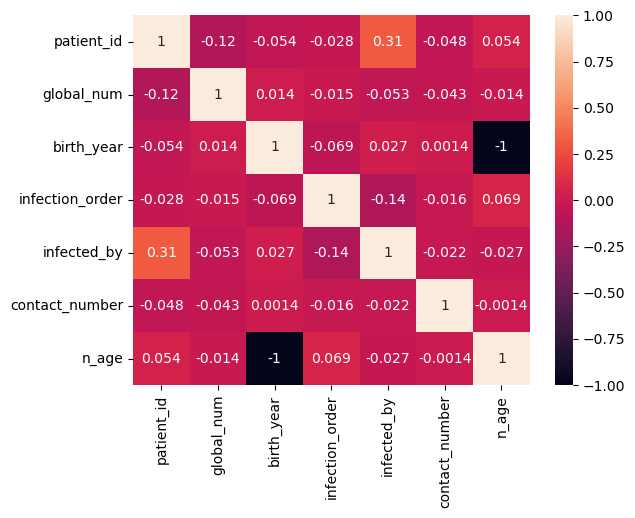

In [474]:
sns.heatmap(df.corr(numeric_only = True), annot = True)
plt.show()

In [475]:
# birth_year is highly correlated with n_age
# can drop it
# and also drop patient_id
df = df.drop(columns=['birth_year', 'patient_id'])
df.columns

Index(['global_num', 'sex', 'age', 'country', 'province', 'city', 'disease',
       'infection_case', 'infection_order', 'infected_by', 'contact_number',
       'state', 'n_age'],
      dtype='object')

**<font color='teal'> Plot the boxplots to check for outliers. </font>**

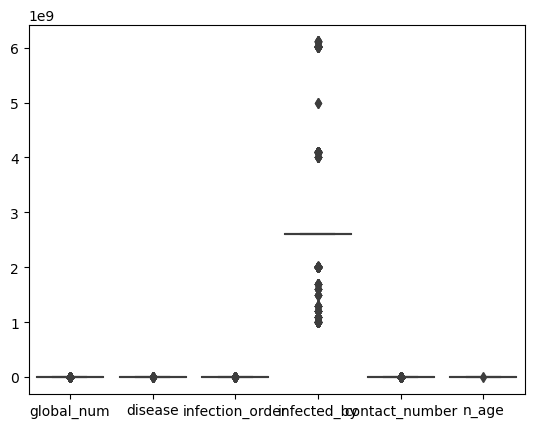

In [476]:
sns.boxplot(df)
plt.show()

**<font color='teal'> Create dummy features for object type features. </font>**

In [477]:
df.head()

,global_num,sex,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age
0,2.0,male,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,2.600789e+09,75.0,released,59.0
1,5.0,male,30s,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.0,2.600789e+09,31.0,released,36.0
2,6.0,male,50s,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,2.002000e+09,17.0,released,59.0
3,7.0,male,30s,Korea,Seoul,Mapo-gu,0,overseas inflow,1.0,2.600789e+09,9.0,released,32.0
4,9.0,female,30s,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,1.000000e+09,2.0,released,31.0


In [478]:
y = df['state'].fillna('missing')
X = df.drop(columns = ['state'], axis = 1)
print(X.shape, y.shape)

(2073, 12) (2073,)


In [479]:
X = pd.get_dummies(X, drop_first = True)
X.head()

C:\Users\wfei2\AppData\Local\Temp\ipykernel_24864\4199012841.py:1: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  X = pd.get_dummies(X, drop_first = True)


,global_num,infection_order,infected_by,contact_number,n_age,sex_male,age_100s,age_10s,age_20s,age_30s,...,infection_case_Pilgrimage to Israel,infection_case_River of Grace Community Church,infection_case_Seongdong-gu APT,infection_case_Shincheonji Church,infection_case_Suyeong-gu Kindergarten,infection_case_contact with patient,infection_case_etc,infection_case_gym facility in Cheonan,infection_case_gym facility in Sejong,infection_case_overseas inflow
0,2.0,1.0,2.600789e+09,75.0,59.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,5.0,1.0,2.600789e+09,31.0,36.0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,6.0,2.0,2.002000e+09,17.0,59.0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,7.0,1.0,2.600789e+09,9.0,32.0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,9.0,2.0,1.000000e+09,2.0,31.0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [483]:
y.unique()

array(['released', 'isolated', 'deceased'], dtype=object)

### Split the data into test and train subsamples

In [484]:
from sklearn.model_selection import train_test_split

# dont forget to define your X and y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

In [485]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1658, 179) (1658,)
(415, 179) (415,)


### Scale data to prep for model creation

In [486]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [487]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [488]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
#lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=0.877
Random Forest: f1-score=0.859


### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [489]:
class_names=['isolated','released','deceased'] # name  of classes

Confusion matrix, without normalization
[[  4   1   0]
 [  1 347  12]
 [  0  37  13]]
Normalized confusion matrix
[[0.8  0.2  0.  ]
 [0.   0.96 0.03]
 [0.   0.74 0.26]]


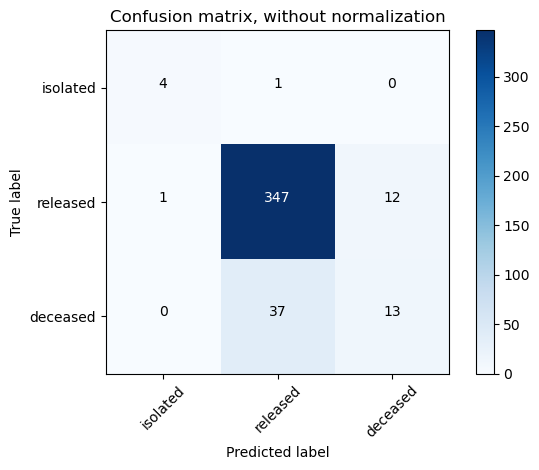

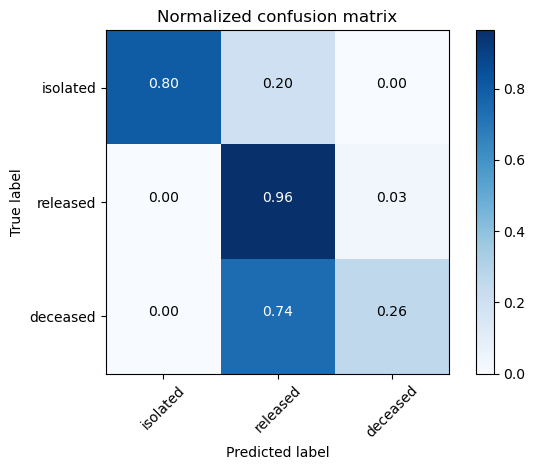

In [490]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# set numpy array print style
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

In [495]:
cnf_matrix

array([[  4,   1,   0],
       [  1, 347,  12],
       [  0,  37,  13]], dtype=int64)

In [493]:
cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

array([[0.8 , 0.2 , 0.  ],
       [0.  , 0.96, 0.03],
       [0.  , 0.74, 0.26]])

In [496]:
cnf_matrix.sum(axis=1)

array([  5, 360,  50], dtype=int64)

In [497]:
cnf_matrix.sum(axis=1)[:, np.newaxis]

array([[  5],
       [360],
       [ 50]], dtype=int64)

In [505]:
cnf_matrix.sum(axis=1)[np.newaxis, :]

array([[  5, 360,  50]], dtype=int64)

In [506]:
cnf_matrix.sum(axis=1)[np.newaxis, :].shape

(1, 3)

In [498]:
cnf_matrix.sum(axis=1).shape

(3,)

In [499]:
cnf_matrix.sum(axis=1)[:, np.newaxis].shape

(3, 1)

In [501]:
cnf_matrix.shape

(3, 3)

**Note:**

**The model suffers from imbalance classes of the target.**

**The model works well for 'released' since it has the most records.**

**But the model does not work well for 'deceased' and 'isolated' which have much less records compared to 'released'.**

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

30
30


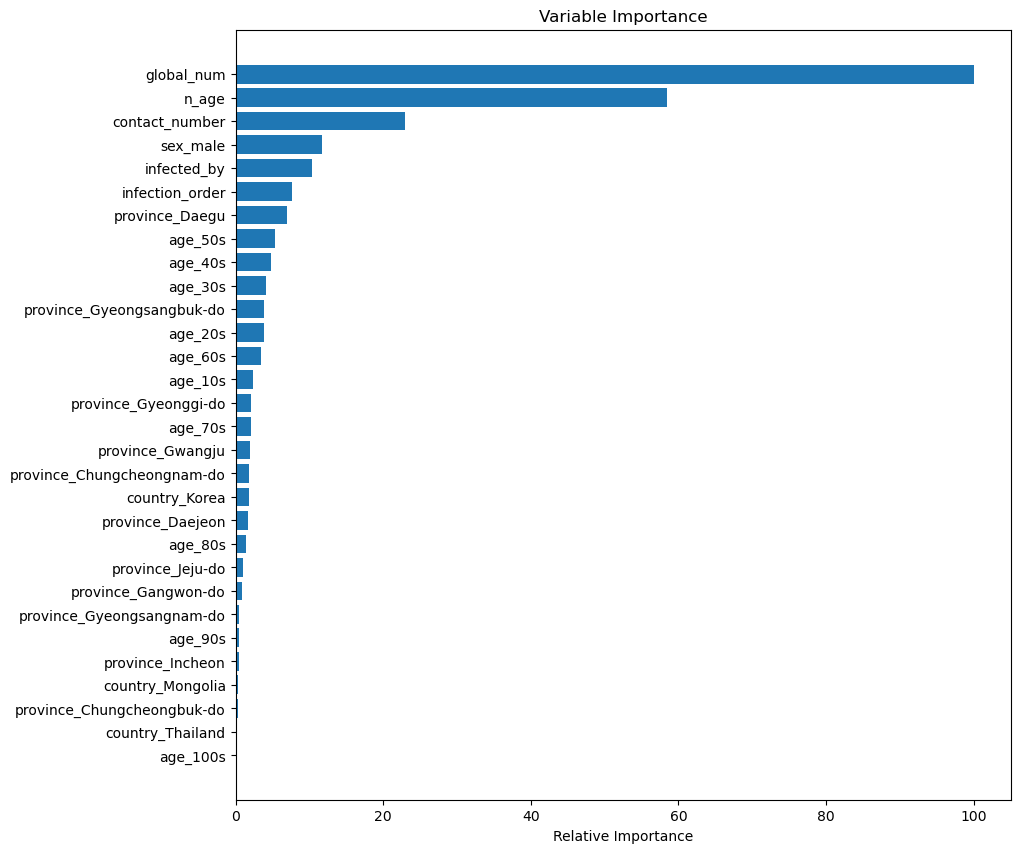

In [492]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
print(sorted_idx.size)
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.